In [1]:
import tqdm
import itertools
import types
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from matplotlib.colors import LinearSegmentedColormap
from sklearn.datasets import make_moons
# PyTorch
import torch
torch.manual_seed(42)
import gpytorch

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import losses
import utils

In [25]:
torch.logspace(0, math.log10(51.2) + 2 * (math.log10(51.2) / 2), steps=5).float()

tensor([1.0000e+00, 7.1554e+00, 5.1200e+01, 3.6636e+02, 2.6214e+03])

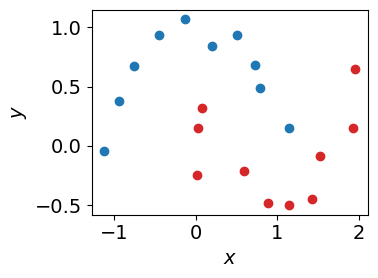

In [3]:
N = 20
X_numpy, y_numpy = make_moons(n_samples=N, noise=0.1, random_state=42)

X = torch.tensor(X_numpy, dtype=torch.float32)
y = torch.tensor(y_numpy.reshape(-1, 1), dtype=torch.float32)

X_train, X_val = X[:int((4/5)*N)], X[int((4/5)*N):]
y_train, y_val = y[:int((4/5)*N)], y[int((4/5)*N):]

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
ax.scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
#ax.set_xlim([-1.4, 2.4])
#ax.set_ylim([-0.9, 1.4])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
fig.tight_layout()
plt.show()

In [4]:
def train_one_epoch(model, criterion, optimizer, X, y, num_samples=1):
    model.train()
    optimizer.zero_grad()
    
    avg_metrics = {}
    for _ in range(num_samples):
        
        logits = model(X)
        params = utils.flatten_params(model)
        metrics = criterion(y, logits, params, len(X))
        metrics['loss'].backward()
        
        for key, value in metrics.items():
            avg_metrics.setdefault(key, 0.0)
            avg_metrics[key] += (1/num_samples) * value.item()
        
    for param in model.parameters():
        if param.grad is not None:
            param.grad.data.mul_(1/num_samples)

    optimizer.step()
    return avg_metrics

def evaluate(model, criterion, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        params = utils.flatten_params(model)
        metrics = criterion(y, logits, params, len(X))
    return metrics

In [18]:
model = layers.RandomFeatureGaussianProcess(in_features=2, out_features=1, learnable_lengthscale=True, learnable_outputscale=True)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
utils.add_variational_layers(model, model.sigma_param)
model.use_posterior = types.MethodType(utils.use_posterior, model)
criterion = losses.KappaELBoLoss(1.0, model.sigma_param, criterion=torch.nn.BCEWithLogitsLoss())

init_state_dict = model.state_dict()
best_state_dict = None
best_metric = np.inf

for lr, weight_decay in itertools.product([0.1, 0.01, 0.001, 0.0001], [0.0]):
    
    model.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    for epoch in tqdm.tqdm(range(10_000)):
        train_metrics = train_one_epoch(model, criterion, optimizer, X, y, 5)

    if train_metrics['loss'] < best_metric:
        best_state_dict = model.state_dict()
        best_metric = train_metrics['loss']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    xx, yy = np.meshgrid(np.arange(-1.4, 2.5, 0.05), np.arange(-0.9, 1.5, 0.05))
    de_elbo_mean_logits = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).reshape(xx.shape)
    de_elbo_mean = torch.nn.functional.sigmoid(de_elbo_mean_logits)
    model.use_posterior(True)
    de_elbo_samples_logits = torch.stack([model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).reshape(xx.shape) for _ in range(100)])
    de_elbo_samples1 = torch.nn.functional.sigmoid(de_elbo_samples_logits)
    #torch.save(de_elbo_mean, 'classification_de_elbo_mean.pt')
    #torch.save(de_elbo_samples, 'classification_de_elbo_samples.pt')

100%|██████████| 10000/10000 [01:50<00:00, 90.38it/s]


In [19]:
model = layers.RandomFeatureGaussianProcess(in_features=2, out_features=1, learnable_lengthscale=True, learnable_outputscale=True)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
utils.add_variational_layers(model, model.sigma_param)
model.use_posterior = types.MethodType(utils.use_posterior, model)
criterion = losses.KappaELBoLoss(3.7133, model.sigma_param, criterion=torch.nn.BCEWithLogitsLoss())

init_state_dict = model.state_dict()
best_state_dict = None
best_metric = np.inf

for lr, weight_decay in itertools.product([0.1, 0.01, 0.001, 0.0001], [0.0]):
    
    model.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    for epoch in tqdm.tqdm(range(10_000)):
        train_metrics = train_one_epoch(model, criterion, optimizer, X, y, 5)

    if train_metrics['loss'] < best_metric:
        best_state_dict = model.state_dict()
        best_metric = train_metrics['loss']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    xx, yy = np.meshgrid(np.arange(-1.4, 2.5, 0.05), np.arange(-0.9, 1.5, 0.05))
    de_elbo_mean_logits = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).reshape(xx.shape)
    de_elbo_mean = torch.nn.functional.sigmoid(de_elbo_mean_logits)
    model.use_posterior(True)
    de_elbo_samples_logits = torch.stack([model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).reshape(xx.shape) for _ in range(100)])
    de_elbo_samples2 = torch.nn.functional.sigmoid(de_elbo_samples_logits)
    #torch.save(de_elbo_mean, 'classification_de_elbo_mean.pt')
    #torch.save(de_elbo_samples, 'classification_de_elbo_samples.pt')

100%|██████████| 10000/10000 [02:43<00:00, 61.05it/s]


In [20]:
model = layers.RandomFeatureGaussianProcess(in_features=2, out_features=1, learnable_lengthscale=True, learnable_outputscale=True)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
utils.add_variational_layers(model, model.sigma_param)
model.use_posterior = types.MethodType(utils.use_posterior, model)
criterion = losses.KappaELBoLoss(13.7884, model.sigma_param, criterion=torch.nn.BCEWithLogitsLoss())

init_state_dict = model.state_dict()
best_state_dict = None
best_metric = np.inf

for lr, weight_decay in itertools.product([0.1, 0.01, 0.001, 0.0001], [0.0]):
    
    model.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    for epoch in tqdm.tqdm(range(10_000)):
        train_metrics = train_one_epoch(model, criterion, optimizer, X, y, 5)

    if train_metrics['loss'] < best_metric:
        best_state_dict = model.state_dict()
        best_metric = train_metrics['loss']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    xx, yy = np.meshgrid(np.arange(-1.4, 2.5, 0.05), np.arange(-0.9, 1.5, 0.05))
    de_elbo_mean_logits = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).reshape(xx.shape)
    de_elbo_mean = torch.nn.functional.sigmoid(de_elbo_mean_logits)
    model.use_posterior(True)
    de_elbo_samples_logits = torch.stack([model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).reshape(xx.shape) for _ in range(100)])
    de_elbo_samples3 = torch.nn.functional.sigmoid(de_elbo_samples_logits)
    #torch.save(de_elbo_mean, 'classification_de_elbo_mean.pt')
    #torch.save(de_elbo_samples, 'classification_de_elbo_samples.pt')

100%|██████████| 10000/10000 [01:50<00:00, 90.80it/s]


In [21]:
model = layers.RandomFeatureGaussianProcess(in_features=2, out_features=1, learnable_lengthscale=True, learnable_outputscale=True)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
utils.add_variational_layers(model, model.sigma_param)
model.use_posterior = types.MethodType(utils.use_posterior, model)
criterion = losses.KappaELBoLoss(51.2, model.sigma_param, criterion=torch.nn.BCEWithLogitsLoss())

init_state_dict = model.state_dict()
best_state_dict = None
best_metric = np.inf

for lr, weight_decay in itertools.product([0.1, 0.01, 0.001, 0.0001], [0.0]):
    
    model.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    for epoch in tqdm.tqdm(range(10_000)):
        train_metrics = train_one_epoch(model, criterion, optimizer, X, y, 5)

    if train_metrics['loss'] < best_metric:
        best_state_dict = model.state_dict()
        best_metric = train_metrics['loss']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    xx, yy = np.meshgrid(np.arange(-1.4, 2.5, 0.05), np.arange(-0.9, 1.5, 0.05))
    de_elbo_mean_logits = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).reshape(xx.shape)
    de_elbo_mean = torch.nn.functional.sigmoid(de_elbo_mean_logits)
    model.use_posterior(True)
    de_elbo_samples_logits = torch.stack([model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).reshape(xx.shape) for _ in range(100)])
    de_elbo_samples4 = torch.nn.functional.sigmoid(de_elbo_samples_logits)
    #torch.save(de_elbo_mean, 'classification_de_elbo_mean.pt')
    #torch.save(de_elbo_samples, 'classification_de_elbo_samples.pt')

100%|██████████| 10000/10000 [01:49<00:00, 91.41it/s]


In [22]:
model = layers.RandomFeatureGaussianProcess(in_features=2, out_features=1, learnable_lengthscale=True, learnable_outputscale=True)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
utils.add_variational_layers(model, model.sigma_param)
model.use_posterior = types.MethodType(utils.use_posterior, model)
criterion = losses.KappaELBoLoss(190.1194, model.sigma_param, criterion=torch.nn.BCEWithLogitsLoss())

init_state_dict = model.state_dict()
best_state_dict = None
best_metric = np.inf

for lr, weight_decay in itertools.product([0.1, 0.01, 0.001, 0.0001], [0.0]):
    
    model.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    for epoch in tqdm.tqdm(range(10_000)):
        train_metrics = train_one_epoch(model, criterion, optimizer, X, y, 5)

    if train_metrics['loss'] < best_metric:
        best_state_dict = model.state_dict()
        best_metric = train_metrics['loss']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    xx, yy = np.meshgrid(np.arange(-1.4, 2.5, 0.05), np.arange(-0.9, 1.5, 0.05))
    de_elbo_mean_logits = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).reshape(xx.shape)
    de_elbo_mean = torch.nn.functional.sigmoid(de_elbo_mean_logits)
    model.use_posterior(True)
    de_elbo_samples_logits = torch.stack([model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).reshape(xx.shape) for _ in range(100)])
    de_elbo_samples5 = torch.nn.functional.sigmoid(de_elbo_samples_logits)
    #torch.save(de_elbo_mean, 'classification_de_elbo_mean.pt')
    #torch.save(de_elbo_samples, 'classification_de_elbo_samples.pt')

100%|██████████| 10000/10000 [02:46<00:00, 59.99it/s]


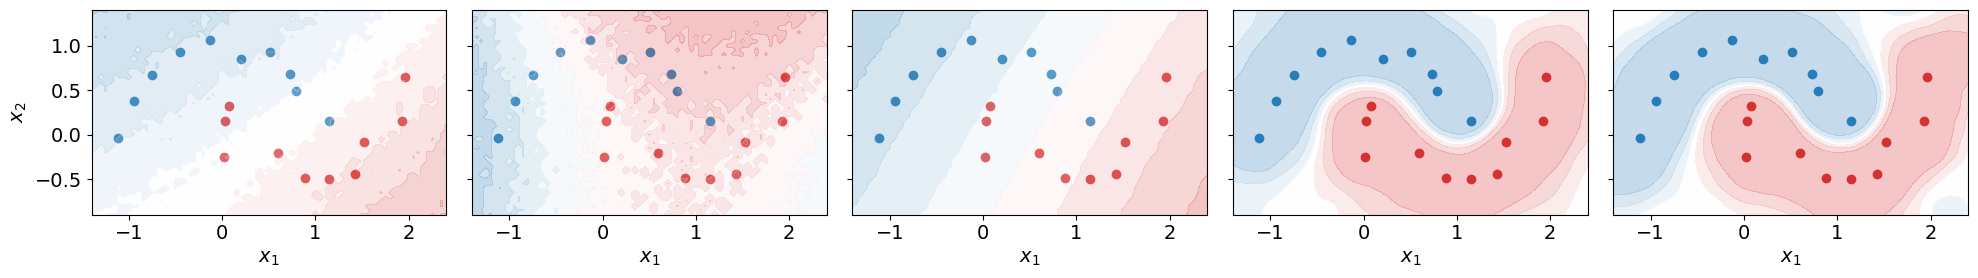

In [23]:
colors = ['#1F77B4', '#5799C7', '#8FBBDA', '#C7DDED', '#FFFFFF', '#F5C9CA', '#EB9394', '#E15D5E', '#D62728']
cmap = LinearSegmentedColormap.from_list('bwr', colors)

xx, yy = np.meshgrid(np.arange(-1.4, 2.5, 0.05), np.arange(-0.9, 1.5, 0.05))

ncols, nrows = 5, 1
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')

axs[0].scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
axs[0].scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
axs[0].contourf(xx, yy, de_elbo_samples1.mean(dim=0), alpha=0.3, cmap=cmap)
axs[0].set_xlim([-1.4, 2.4])
axs[0].set_ylim([-0.9, 1.4])
axs[0].set_xlabel(r'$x_1$')
axs[0].set_ylabel(r'$x_2$')

axs[1].scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
axs[1].scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
axs[1].contourf(xx, yy, de_elbo_samples2.mean(dim=0), alpha=0.3, cmap=cmap)
axs[1].set_xlim([-1.4, 2.4])
axs[1].set_ylim([-0.9, 1.4])
axs[1].set_xlabel(r'$x_1$')

axs[2].scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
axs[2].scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
axs[2].contourf(xx, yy, de_elbo_samples3.mean(dim=0), alpha=0.3, cmap=cmap)
axs[2].set_xlim([-1.4, 2.4])
axs[2].set_ylim([-0.9, 1.4])
axs[2].set_xlabel(r'$x_1$')

axs[3].scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
axs[3].scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
axs[3].contourf(xx, yy, de_elbo_samples4.mean(dim=0), alpha=0.3, cmap=cmap)
axs[3].set_xlim([-1.4, 2.4])
axs[3].set_ylim([-0.9, 1.4])
axs[3].set_xlabel(r'$x_1$')

axs[4].scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
axs[4].scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
axs[4].contourf(xx, yy, de_elbo_samples5.mean(dim=0), alpha=0.3, cmap=cmap)
axs[4].set_xlim([-1.4, 2.4])
axs[4].set_ylim([-0.9, 1.4])
axs[4].set_xlabel(r'$x_1$')

fig.tight_layout()
#fig.savefig('classification_demo.pdf', bbox_inches='tight')
plt.show()